<a href="https://colab.research.google.com/github/stefphd/bicycle-lnn/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lagragian Neural Network for Bycicle Dynamics

This code identify the bicycle dynamics using a Lagragian Neural Network, with the method proposed in [this paper](https://arxiv.org/abs/2003.04630). This is similar to the DeLaN method (see [this papar](https://arxiv.org/abs/1907.04490)), with the difference that the method is suitable for system involving Lagragian of different forms, including e.g. non-holonomic contraints (as in the bicycle dynamics). The DeLaN method is instead confined to mechanical systems having potential and kinetic energy only (e.g. standard robots).

## Set environment

### Set the Python environment

Python 3.7 is being used for compatibility. Here the Python version is forced to be 3.7 (just installation and setting stuff).

In [82]:
!sudo apt update -y # update repos
!sudo apt install python3.7 # install python 3.7
from IPython.display import clear_output # just to clean the output of Colab
clear_output()
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1 # set installed python3.7 as python3
!sudo apt install python3-pip # install pip
!sudo apt install python3.7-distutils # install distutils according to the installer python version
clear_output()
!python3 --version # check the version

Python 3.7.17


### Install and Import Python Packages

Required Python packages are:

* jax (version 0.1.58) & jaxlib (version 0.1.36)
* numpy (included with jaxlib installation)

In [83]:
!pip install install --upgrade https://storage.googleapis.com/jax-releases/cuda101/jaxlib-0.1.36-cp37-none-linux_x86_64.whl
!pip install --upgrade -q jax==0.1.58

  Using cached https://storage.googleapis.com/jax-releases/cuda101/jaxlib-0.1.36-cp37-none-linux_x86_64.whl (48.2 MB)


In [85]:
# jax imports
import jax
import jax.numpy as jnp
from jax.example_libraries import stax
from jax.example_libraries import optimizers

# utils
import scipy.io as scio# to import mat files
import numpy as np

# visualization
import matplotlib.pyplot as plt
from functools import partial # reduces args to function by making some subset implicit

## Data elaboration

### Import the data

Experimental bicycle data are imported from a MAT file.

In [87]:
filename = "https://github.com/stefphd/bicycle-lnn/raw/main/data/2022-09-14_FrequencyBand_20kph-test1.mat" # name of the data file (MAT)

!wget {filename} -O "data.mat"
clear_output()
datamat = scio.loadmat("data.mat")

print(datamat.keys()) # print fields of datamat
datamat["time"] = datamat["time"] - datamat["time"][0]; # set initial time to 0
datamat["sample"] = datamat["sample"] - datamat["sample"][0]; # set initial sample to 0


dict_keys(['__header__', '__version__', '__globals__', 'speed', 'distance', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'mag_x', 'mag_y', 'mag_z', 'latitude', 'longitude', 'gps_speed', 'steer_angle', 'steer_rate', 'fork_disp', 'curr_act', 'steer_torque', 'cpu_temp', 'voltage', 'err_state_in', 'curr_ref', 'throttle', 'roll_est', 'yaw_est', 'pos_est_x', 'pos_est_y', 'err_state_out', 'user_data1', 'user_data2', 'user_data3', 'user_data4', 'sample', 'time'])


### Split train and test data

Train and test data are splitted according to a factor.

In [103]:
trainfactor = 0.8 # from 0 to 1 (usually 0.8?), percentage of data used for training (1-train_factor is used for testing)

datalen = len(datamat["time"])
splitlen = round(trainfactor*datalen)

# split data
traindata = dict() # train data
testdata = dict() # test data
for key in datamat.keys():
  if type(datamat[key]) is np.ndarray:
    traindata[key] = datamat[key][:splitlen]
    testdata[key] = datamat[key][(splitlen+1):]

trainsize = len(traindata["time"])
testsize = len(testdata["time"])
trainperc = trainsize / datalen
testperc = testsize / datalen

# print lenghts
print("Train data length: %d (%f%%)" % (trainsize, trainperc))
print("Test data length: %d (%f%%)" % (testsize, testperc))


Train data length: 150401 (0.800001%)
Test data length: 37599 (0.199994%)


### Plot essential data

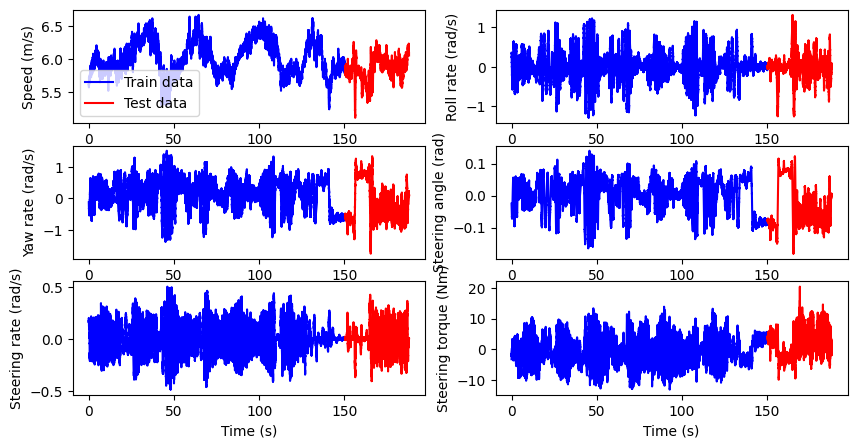

In [106]:
# some plots just to see the data
trainlinespecs = 'b-'
testlinespecs = 'r-'

plt.figure(figsize=[10,5])

plt.subplot(3,2,1) # speed
plt.plot(traindata["time"], traindata["speed"], trainlinespecs, label="Train data")
plt.plot(testdata["time"], testdata["speed"], testlinespecs, label="Test data")
plt.ylabel("Speed (m/s)")
plt.legend()

plt.subplot(3,2,2) # roll rate
plt.plot(traindata["time"], traindata["gyro_x"], trainlinespecs, label="Train data")
plt.plot(testdata["time"], testdata["gyro_x"], testlinespecs, label="Test data")
plt.ylabel("Roll rate (rad/s)")

plt.subplot(3,2,3) # yaw rate
plt.plot(traindata["time"], traindata["gyro_z"], trainlinespecs, label="Train data")
plt.plot(testdata["time"], testdata["gyro_z"], testlinespecs, label="Test data")
plt.ylabel("Yaw rate (rad/s)")

plt.subplot(3,2,4) # steering angle
plt.plot(traindata["time"], traindata["steer_angle"], trainlinespecs, label="Train data")
plt.plot(testdata["time"], testdata["steer_angle"], testlinespecs, label="Test data")
plt.ylabel("Steering angle (rad)")

plt.subplot(3,2,5) # steering angle
plt.plot(traindata["time"], traindata["steer_rate"], trainlinespecs, label="Train data")
plt.plot(testdata["time"], testdata["steer_rate"], testlinespecs, label="Test data")
plt.ylabel("Steering rate (rad/s)")

plt.xlabel("Time (s)")

plt.subplot(3,2,6) # steering torque
plt.plot(traindata["time"], traindata["steer_torque"], trainlinespecs, label="Train data")
plt.plot(testdata["time"], testdata["steer_torque"], testlinespecs, label="Test data")
plt.ylabel("Steering torque (Nm)")

plt.xlabel("Time (s)")

plt.show()